In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

In [2]:
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras import Model

In [3]:
from mtgsdk import Card
from mtgsdk import Set
from mtgsdk import Type
from mtgsdk import Supertype
from mtgsdk import Subtype
from mtgsdk import Changelog

In [4]:
import requests
import shutil
import os

ideas: augment data

In [5]:
#useful links
# mtg sdk: https://github.com/MagicTheGathering/mtg-sdk-python
# scryfall api for images: https://scryfall.com/docs/api/cards
# useful paper: http://cs231n.stanford.edu/reports/2017/pdfs/406.pdf

# Project Outline:

1. Get the art data
2. Create CNN
3. Make Art?

In [6]:
import time

def get_multiverse_id_artist(artist):
    cards = Card.where(artist=artist).all()
    return cards

def print_card_list(input_card_list):
    for i in input_card_list:
        print(i.name)

def get_image_uri(input_multiverse_id):
    """Get the uris of image (without card border) in the input_multiverse_id
    from the scryfall api
    Args:
        input_multiverse_id -- id for mtg card to get url for
    Returns:
        image_url -- list of image url
    """
    
    api_link = "https://api.scryfall.com/cards/multiverse/{}".format(input_multiverse_id)
    response = requests.get(api_link)
    if response.status_code==200:
        response_json = response.json()
        image_uri = response_json["image_uris"]["art_crop"]
        time.sleep(.1) #API requests to wait 50-100 ms per request
        return image_uri
    else:
        return None


def download_images(cards, folder_dir):
    """ Download all images of the list of cards to the folder dir
    Args:
        image_urls -- list of cards' images to download
        folder_dir -- relative folder directory to save them in
    """
    
    for card in cards:
        filename = folder_dir+"{}".format(card.multiverse_id)
        filename = filename+'.jpg'
        # Only download if the file doesn't exist or exists and is of zero size for some reason
        if (os.path.exists(filename)==False) or (os.path.exists(filename)==True and os.path.getsize(filename)<10):
            image_uri = get_image_uri(card.multiverse_id)
            
            if image_uri is not None:
                response = requests.get(image_uri, stream = True)
                time.sleep(.1) #API requests to wait 50-100 ms per request
            
                # download the image if the status code is fine
                if response.status_code==200:
                    response.raw.decode_content=True            
                    try:
                        with open(filename, 'wb') as f:
                            shutil.copyfileobj(response.raw, f)
                    except:
                        pass
   

In [7]:
# Download Rebecca Guay Card Images
card_list_guay = get_multiverse_id_artist('Rebecca Guay')
download_images(card_list_guay, 'img/guay/')

In [8]:
num_guay_images = len([name for name in os.listdir('img/guay/') if os.path.isfile('img/guay/'+name) and name[-3:]=='jpg'])
print(num_guay_images)

251


In [9]:
# Download all M20 cards to train. Rebecca Guay has no cards 
# that she did the art for in m20
cards_not_guay = Card.where(set='m20').all()

In [10]:
download_images(cards_not_guay, 'img/not_guay/')

In [11]:
num_not_guay_images = len([name for name in os.listdir('img/not_guay/') if os.path.isfile('img/not_guay/'+name) and name[-3:]=='jpg'])
print(num_not_guay_images)

344


In [12]:
BATCH_SIZE=32
IMG_SIZE = (160, 160)
img_dir = "img/"

In [13]:
train_dataset = tf.keras.utils.image_dataset_from_directory(img_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
class_names = train_dataset.class_names

Found 596 files belonging to 2 classes.


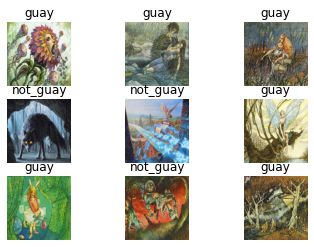

In [14]:
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
# Take 20 percent of the training data for validation, then will remove
# 50 percent of the validation data to test data
train_batches = tf.data.experimental.cardinality(train_dataset)
validation_dataset = train_dataset.take(train_batches//5)
train_dataset = train_dataset.skip(train_batches // 5)

In [16]:
validation_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_batches//2)
validation_dataset = validation_dataset.skip(validation_batches//2)

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [18]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 1


In [19]:
# Augment the data
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

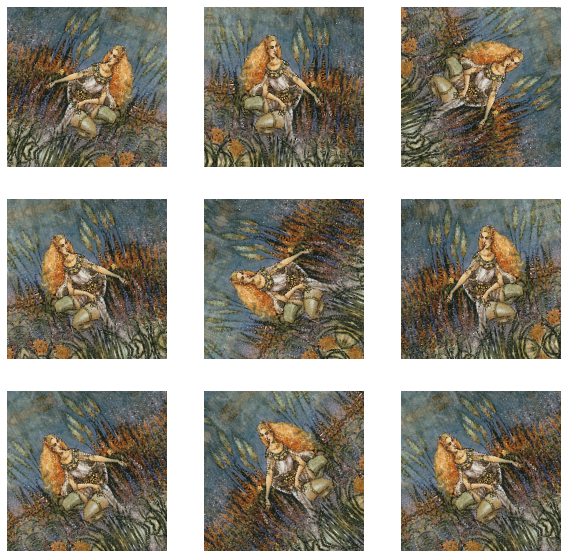

In [20]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [21]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [22]:
IMG_SHAPE = IMG_SIZE + (3,)

In [23]:
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

In [24]:
base_model.trainable=False

In [25]:
last_layer = base_model.get_layer('conv5_block3_out')
last_output = last_layer.output

In [26]:
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [27]:
model = Model(base_model.input, x)

In [28]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [29]:
history = model.fit(
            train_dataset,
            validation_data = validation_dataset, 
            epochs = 1)

16/16 [==============================] - 15s 838ms/step - loss: 0.5472 - accuracy: 0.8340 - val_loss: 0.1215 - val_accuracy: 0.9688


In [30]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 962ms/step - loss: 0.1117 - accuracy: 0.9688
Test accuracy : 0.96875


In [31]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.where(predictions < 0.5, 0, 1)
predictions = predictions.numpy().T
predictions = np.array([i for i in predictions[0]])
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

Predictions:
 [1 1 1 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0]
Labels:
 [1 1 1 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1]


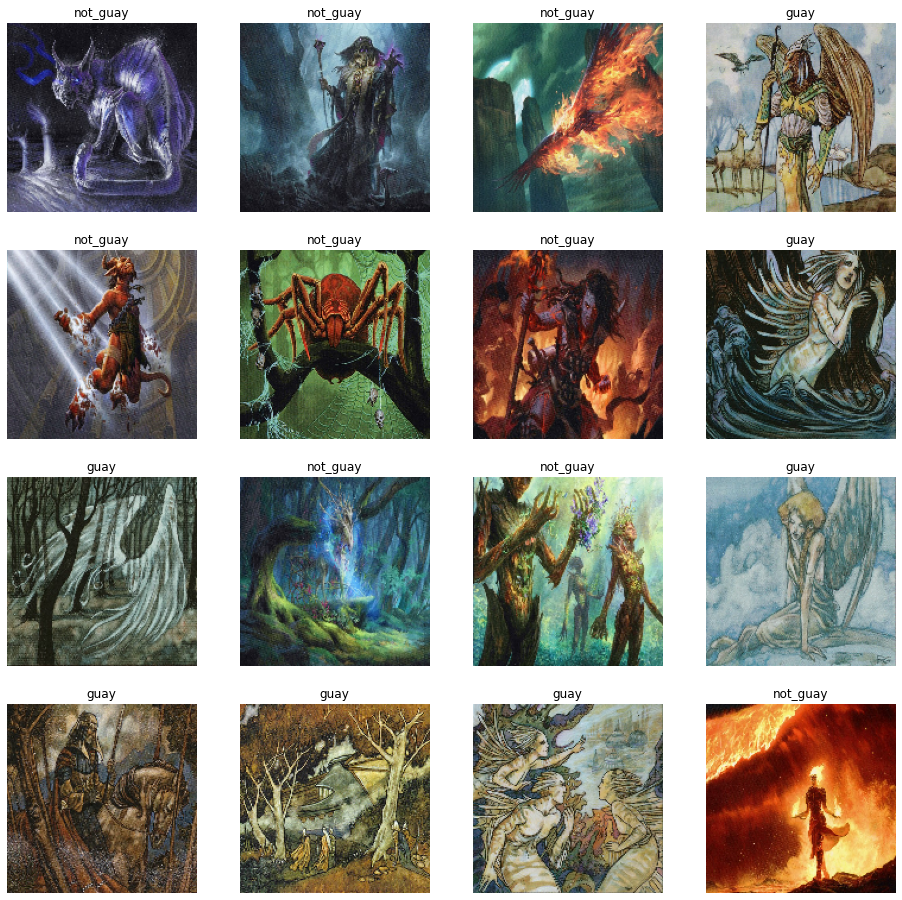

In [32]:
plt.figure(figsize=(16, 16))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")
